<div class="alert" style="background-color:#fff; color:white; padding:0px 10px; border-radius:5px;"><h1 style='margin:15px 15px; color:#006a79; font-size:40px'>Predicting Rush Or Pass LightGBM Model With Feature Engineering</h1>
</div>

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Setup Environment</h2>
</div>

In [1]:
#Import Libraries
import pandas as pd
import numpy as np
import nfl_data_py as nfl
import re

pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 500)

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, brier_score_loss, log_loss, roc_auc_score
import lightgbm as lgb

# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import ConfusionMatrixDisplay
from lightgbm import LGBMClassifier
from lightgbm import early_stopping, log_evaluation
from sklearn.model_selection import GroupKFold
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.calibration import calibration_curve

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Load Data</h2>
</div>

In [2]:
years = [2024]
play_by_play = nfl.import_pbp_data(years, downcast=True, cache=False)

2024 done.
Downcasting floats.


<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Data preprocessing (label creation + basic cleaning)</h2>
</div>

In [3]:
play_by_play["play_type"].value_counts(dropna=False)

pass           20006
run            15044
no_play         4934
kickoff         2949
punt            2119
None            1460
extra_point     1302
field_goal      1166
qb_kneel         437
qb_spike          75
Name: play_type, dtype: int64

In [4]:
# normalize the play_type string (safe for NaN)
play_by_play['play_type_norm'] = play_by_play['play_type'].astype(str).str.strip().str.lower()

# strict mapping: only exact 'pass' and 'run' become those classes; everything else -> 'other'
def simple_map(x):
    if x == 'pass':
        return 'pass'
    if x == 'run':
        return 'run'
    return 'other'

play_by_play['play_type_simple'] = play_by_play['play_type_norm'].apply(simple_map).astype('category')

# print counts
print("Counts:")
print(play_by_play['play_type_simple'].value_counts(dropna=False))

# drop intermediate column play_type_norm
play_by_play.drop(['play_type_norm'],axis=1,inplace=True)

Counts:
pass     20006
run      15044
other    14442
Name: play_type_simple, dtype: int64


In [5]:
# add next play type by first sorting and grouping
play_by_play["down_sort"] = play_by_play["down"].fillna(0)  # NaN downs (kickoffs/returns) become 0
play_by_play_sorted = play_by_play.sort_values(
    by=["game_id", "game_seconds_remaining", "down_sort", "play_id"],
    ascending=[True, False, True, True]
).drop(columns="down_sort")

# then grouping
play_by_play_sorted["next_play_type"] = (
    play_by_play_sorted.groupby("game_id")["play_type_simple"]
      .shift(-1)   # shift backwards → next row’s play_type
)

play_by_play_sorted["next_play_type"]

0        other
1          run
2         pass
3         pass
4          run
         ...  
49487    other
49488    other
49489    other
49490    other
49491      NaN
Name: next_play_type, Length: 49492, dtype: category
Categories (3, object): ['other', 'pass', 'run']

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Model Building with Feature Engineering</h2>
</div>

In [6]:
# Step 0: Drop columns that are IDs, free text, or meaningless at decision time
def prepare_next_play_dataset(
    df: pd.DataFrame,
    id_and_text_drop=None,
    run_labels=("run", "rush"),   # handle naming differences
    pass_labels=("pass",),
    game_sort_cols=("game_id", "game_seconds_remaining", "play_id")
):
    """
    Build a leakage-safe dataset for predicting the *next* play (pass/run) by the *same offense*.
    Returns: X (features), y (0=run,1=pass), groups (game_id), base_df (cleaned working frame)
    """

    # ---- 0.1 Sort plays within games (descending clock; play_id ensures tie-break)
    sort_cols = list(game_sort_cols)
    ascending = [True] + [False] * (len(sort_cols) - 1)  # game_id asc, then desc for the rest
    df = df.sort_values(sort_cols, ascending=ascending).copy()

    # ---- 0.2 Build next-play fields within each game
    g = df.groupby("game_id", sort=False)

    # Who has the ball next?
    df["next_posteam"] = g["posteam"].shift(-1)

    # What is the next play type (string) so we can create a label?
    # Your data likely has 'play_type_simple' (nflfastR). Adjust here if needed.
    next_playtype_col = (
        g["play_type_simple"].shift(-1)
        if "play_type_simple" in df.columns
        else g["play_type"].shift(-1)
    )
    df["next_playtype"] = next_playtype_col.astype(str).str.lower()

    # ---- 0.3 Keep only rows where the *same team* will snap the next play
    same_team_mask = (df["next_posteam"] == df["posteam"])

    # ---- 0.4 Keep only rows where the next play is a pure run or pass
    run_set  = set(s.lower() for s in run_labels)
    pass_set = set(s.lower() for s in pass_labels)
    next_is_run  = df["next_playtype"].isin(run_set)
    next_is_pass = df["next_playtype"].isin(pass_set)

    keep_mask = same_team_mask & (next_is_run | next_is_pass)

    work = df.loc[keep_mask].copy()

    # ---- 0.5 Create the binary label for the *next* play
    work["target_pass_next"] = (work["next_playtype"].isin(pass_set)).astype(int)

    # ---- 0.6 Drop obvious leakage/noise: IDs, free text, timestamps that uniquely ID a play, etc.
    default_id_and_text_drop = [
        # Free text / near-unique
        "desc",
        # Pure identifiers / hashes
        "old_game_id", "play_id",
        # Raw time strings
        "drive_real_start_time", "drive_game_clock_start", "drive_game_clock_end",
        # Duplicative drive boundary IDs
        "drive_play_id_started", "drive_play_id_ended",
    ]
    if id_and_text_drop is None:
        id_and_text_drop = default_id_and_text_drop
    # Drop only if present
    to_drop = [c for c in id_and_text_drop if c in work.columns]
    if to_drop:
        work = work.drop(columns=to_drop)

    # ---- 0.7 (Important) Keep game_id for grouping, but exclude it from X later
    groups = work["game_id"].copy()

    # ---- 0.8 Remove helper/label columns from features
    helper_cols = ["next_posteam", "next_playtype", "target_pass_next"]
    feature_cols = [c for c in work.columns if c not in (helper_cols + ["game_id"])]

    # ---- 0.9 Cast object→category (after dropping free text) to help LightGBM
    obj_cols = [c for c in feature_cols if work[c].dtype == "object"]
    for c in obj_cols:
        work[c] = work[c].astype("category")

    X = work[feature_cols]
    y = work["target_pass_next"].astype(int)

    return X, y, groups, work

In [7]:
# ===== Step 1: Next-state context (what the OC sees before the next snap) =====
def add_next_state_features(work: pd.DataFrame) -> pd.DataFrame:
    g = work.groupby("game_id", sort=False)
    for col in ["down","ydstogo","yardline_100","score_differential","wp"]:
        work[f"next_{col}"] = g[col].shift(-1)

    work["next_down_cat"] = work["next_down"].astype("Int64")
    work["next_yds_bin"] = pd.cut(work["next_ydstogo"],
                                  bins=[-1,1,3,6,10,15,99],
                                  labels=["1","2-3","4-6","7-10","11-15","16+"])
    work["next_field_zone"] = pd.cut(work["next_yardline_100"],
                                     bins=[-1,20,50,80,100],
                                     labels=["backed_up","own_half","opp_half","redzone"])
    work["next_score_bucket"] = pd.cut(work["next_score_differential"],
                                       bins=[-99,-7,7,99],
                                       labels=["trailing","close","ahead"])
    work["clock_bucket"] = pd.cut(work["game_seconds_remaining"].fillna(-1),
                                  bins=[-1,120,240,600,1800,3600],
                                  labels=["2min","2-4min","4-10min","10-30min","early"])
    for c in ["next_down_cat","next_yds_bin","next_field_zone","next_score_bucket","clock_bucket"]:
        work[c] = work[c].astype("category")
    return work

In [8]:
def add_short_term_history_features(work: pd.DataFrame) -> pd.DataFrame:
    """
    Leakage-safe short-term history features.
    Assumes columns: game_id, posteam, play_type_simple (or play_type),
                     success, epa, yards_gained, game_seconds_remaining,
                     optional: drive, penalty, penalty_yards, sack, shotgun, no_huddle.
    """
    work = work.copy()

    # --- normalize current play type ---
    if "play_type_simple" in work.columns:
        cur_type = work["play_type_simple"].astype(str).str.lower()
    else:
        cur_type = work.get("play_type", pd.Series(index=work.index, dtype="object")).astype(str).str.lower()

    work["is_pass_now"] = (cur_type == "pass").astype(int)
    work["is_run_now"]  = (cur_type.isin(["run", "rush"])).astype(int)

    # group helpers
    g_team_game = work.groupby(["game_id", "posteam"], sort=False)

    # --- recent pass-rate windows (team within game) ---
    for w in (3, 5, 10):
        work[f"team_pass_rate_w{w}"] = g_team_game["is_pass_now"].transform(
            lambda s: s.shift(1).rolling(w, min_periods=1).mean()
        )

    # --- drive-scoped pass-rate windows (use transform to keep index flat) ---
    if "drive" in work.columns:
        g_tg_drive = work.groupby(["game_id", "posteam", "drive"], sort=False)
        for w in (3, 5, 10):
            work[f"drive_pass_rate_w{w}"] = g_tg_drive["is_pass_now"].transform(
                lambda s: s.shift(1).rolling(w, min_periods=1).mean()
            )

    # --- streaks entering the row (consecutive same-type BEFORE this play) ---
    def _prior_streak(series: pd.Series) -> pd.Series:
        out = np.zeros(len(series), dtype=int)
        prev = None
        count = 0
        vals = series.to_numpy()
        for i, v in enumerate(vals):
            if prev is None or v != prev:
                count = 0
            else:
                count += 1
            out[i] = count
            prev = v
        return pd.Series(out, index=series.index)

    work["pass_streak"] = g_team_game["is_pass_now"].transform(_prior_streak)
    work["run_streak"]  = g_team_game["is_run_now"].transform(_prior_streak)

    # --- last play outcomes (carryover) ---
    work["prev_success"] = g_team_game["success"].shift(1).fillna(0).astype(float)

    work["prev_epa"] = g_team_game["epa"].shift(1).astype(float)
    work["prev_epa_bucket"] = pd.cut(
        work["prev_epa"].fillna(0.0),
        bins=[-10, -2.0, -0.5, 0.0, 0.5, 2.0, 10],
        labels=["catastrophic","bad","minus","neutral","plus","explosive"]
    )

    work["prev_yards"] = g_team_game["yards_gained"].shift(1).astype(float)
    work["prev_yards_bucket"] = pd.cut(
        work["prev_yards"].fillna(0.0),
        bins=[-10, -1, 0, 3, 7, 15, 60],
        labels=["loss","stuffed","no_gain","short","chunk","explosive"]
    )

    # penalties: use explicit flag if present, else proxy from penalty_yards
    if "penalty" in work.columns:
        work["prev_penalty_flag"] = g_team_game["penalty"].shift(1).fillna(0).astype(int)
    else:
        work["penalty_proxy"] = (work.get("penalty_yards", pd.Series(0, index=work.index)).abs() > 0).astype(int)
        work["prev_penalty_flag"] = g_team_game["penalty_proxy"].shift(1).fillna(0).astype(int)

    if "sack" in work.columns:
        work["prev_sack_flag"] = g_team_game["sack"].shift(1).fillna(0).astype(int)

    # --- tempo / formation carryover ---
    work["delta_secs_prev"] = (
        g_team_game["game_seconds_remaining"].shift(1) - work["game_seconds_remaining"]
    )

    work["tempo_bucket"] = pd.cut(
        work["delta_secs_prev"].fillna(-1),
        bins=[-1, 10, 20, 35, 60, 120, 10000],
        labels=["hyper","fast","normal","leisurely","slow","stoppage"]
    )

    if "shotgun" in work.columns:
        work["shotgun_prev"] = g_team_game["shotgun"].shift(1).fillna(0).astype(int)
    if "no_huddle" in work.columns:
        work["no_huddle_prev"] = g_team_game["no_huddle"].shift(1).fillna(0).astype(int)

    # --- tidy types for buckets only (keep rates as numeric) ---
    for c in ["prev_epa_bucket", "prev_yards_bucket", "tempo_bucket"]:
        if c in work.columns:
            work[c] = work[c].astype("category")

    return work

In [9]:
def add_tendency_features(work: pd.DataFrame, k: float = 100.0, league_p: float = None) -> pd.DataFrame:
    """
    Expanding (leakage-safe) tendencies with Bayesian smoothing.
    Creates coach/team/defense priors overall, by next down, and (coach) by next distance bin.
    Only uses past info: cumulative sums are shifted by 1 (as-of BEFORE current row).
    """
    work = work.copy()

    # --- prerequisites / safety ---
    if "is_pass_now" not in work.columns:
        cur_type = work.get("play_type_simple", work.get("play_type", pd.Series(index=work.index, dtype="object"))).astype(str).str.lower()
        work["is_pass_now"] = (cur_type == "pass").astype(int)

    work["down_cat_now"] = work["down"].astype("Int64")

    # offense coach on this play
    if "off_coach" not in work.columns:
        if {"home_team","away_team","home_coach","away_coach"}.issubset(work.columns):
            work["off_coach"] = np.where(work["posteam"] == work["home_team"], work["home_coach"], work["away_coach"])
        else:
            work["off_coach"] = work.get("coach", pd.Series("UNK", index=work.index))
    # NOTE: do NOT fillna in place on Categoricals (causes ValueError); the helper handles it.

    # current distance bins (used to build "as-of" series; later we pick by NEXT bins)
    dist_labels = ["1","2-3","4-6","7-10","11-15","16+"]
    work["yds_bin_now"] = pd.cut(work["ydstogo"], bins=[-1,1,3,6,10,15,99], labels=dist_labels)

    # league prior (ideally compute from train only)
    if league_p is None:
        league_p = float(work["is_pass_now"].mean())

    # Helper: smoothed expanding rate "as-of BEFORE this row"
    def _smoothed_expanding_for_condition(group_key: pd.Series, cond_bool: pd.Series) -> pd.Series:
        # make a local, NA-safe grouping key (object dtype)
        gk = pd.Series(group_key, index=work.index)
        if str(gk.dtype) == "category":
            gk = gk.astype("object")
        gk = gk.where(~gk.isna(), "UNK")

        cb = pd.Series(cond_bool, index=work.index).fillna(False).astype(int)

        inc = cb
        pass_inc = work["is_pass_now"] * inc

        cum_n = inc.groupby(gk).cumsum()
        cum_p = pass_inc.groupby(gk).cumsum()

        cum_n_prev = cum_n.groupby(gk).shift(1).fillna(0.0)
        cum_p_prev = cum_p.groupby(gk).shift(1).fillna(0.0)

        num = k * league_p + cum_p_prev
        den = k + cum_n_prev
        return num / den

    # --------------------------
    # Coach: overall tendency
    # --------------------------
    work["coach_pass_rate_overall"] = _smoothed_expanding_for_condition(
        group_key=work["off_coach"],
        cond_bool=pd.Series(True, index=work.index)
    )

    # --------------------------
    # Coach: by NEXT down
    # --------------------------
    for d in (1,2,3,4):
        work[f"coach_pass_rate_down{d}_asof"] = _smoothed_expanding_for_condition(
            group_key=work["off_coach"],
            cond_bool=work["down_cat_now"].eq(d)
        )

    def _pick_by_next_down(row, prefix):
        nd = row.get("next_down")
        if pd.isna(nd):
            return np.nan
        d = int(nd)
        return row.get(f"{prefix}{d}_asof", np.nan)

    work["coach_down_pass_rate_next"] = work.apply(
        lambda r: _pick_by_next_down(r, "coach_pass_rate_down"), axis=1
    )

    # --------------------------
    # Coach: by NEXT distance bin
    # --------------------------
    for lab in dist_labels:
        work[f"coach_pass_rate_dist_{lab}_asof"] = _smoothed_expanding_for_condition(
            group_key=work["off_coach"],
            cond_bool=work["yds_bin_now"].astype(str).eq(str(lab))
        )

    def _pick_by_next_dist(row):
        lab = row.get("next_yds_bin")
        if pd.isna(lab):
            return np.nan
        return row.get(f"coach_pass_rate_dist_{str(lab)}_asof", np.nan)

    work["coach_dist_pass_rate_next"] = work.apply(_pick_by_next_dist, axis=1)

    # --------------------------
    # Team: overall + by NEXT down
    # --------------------------
    work["team_pass_rate_overall"] = _smoothed_expanding_for_condition(
        group_key=work["posteam"],
        cond_bool=pd.Series(True, index=work.index)
    )
    for d in (1,2,3,4):
        work[f"team_pass_rate_down{d}_asof"] = _smoothed_expanding_for_condition(
            group_key=work["posteam"],
            cond_bool=work["down_cat_now"].eq(d)
        )
    work["team_down_pass_rate_next"] = work.apply(
        lambda r: _pick_by_next_down(r, "team_pass_rate_down"), axis=1
    )

    # --------------------------
    # Defense: overall + by NEXT down
    # --------------------------
    work["def_pass_allowed_overall"] = _smoothed_expanding_for_condition(
        group_key=work["defteam"],
        cond_bool=pd.Series(True, index=work.index)
    )
    for d in (1,2,3,4):
        work[f"def_pass_allowed_down{d}_asof"] = _smoothed_expanding_for_condition(
            group_key=work["defteam"],
            cond_bool=work["down_cat_now"].eq(d)
        )
    work["def_down_pass_allowed_next"] = work.apply(
        lambda r: _pick_by_next_down(r, "def_pass_allowed_down"), axis=1
    )

    # (Optional) drop helper columns after inspection:
    # work = work.drop(columns=[c for c in work.columns if c.endswith("_asof")])

    return work

In [10]:
def add_environment_features(work: pd.DataFrame) -> pd.DataFrame:
    """
    Environment + context features known before the next snap:
      - Roof (indoor/outdoor), surface (grass/turf), temp & wind (cleaned + bins), precip flags
      - Offense home/away on NEXT snap
      - NEXT snap timeouts remaining for offense (and bucket)
      - NEXT snap two-minute situation flags (by quarter / by half if available)
    Assumes columns may include:
      roof, surface, temp, wind, weather, humidity,
      game_id, qtr, game_seconds_remaining, half_seconds_remaining,
      home_team, away_team, posteam, next_posteam,
      home_timeouts_remaining, away_timeouts_remaining
    Works gracefully if some columns are missing.
    """
    work = work.copy()

    # ---------- 1) Normalize roof / surface ----------
    def _norm_roof(s: pd.Series) -> pd.Series:
        x = s.astype(str).str.lower()
        # nflfastR typically: 'outdoors', 'dome', 'closed'
        x = x.replace({
            "na": np.nan, "nan": np.nan, "none": np.nan,
            "retractable": "closed", "open": "outdoors"
        })
        cat = pd.Series(np.where(x.isin(["dome","closed"]), "indoor",
                         np.where(x.isin(["outdoor","outdoors"]), "outdoor", "unknown")),
                        index=s.index)
        return cat.astype("category")

    def _norm_surface(s: pd.Series) -> pd.Series:
        x = s.astype(str).str.lower()
        x = x.replace({"artificial": "turf", "fieldturf": "turf", "astroplay": "turf"})
        cat = pd.Series(np.where(x.str.contains("turf|artificial|astro", na=False), "turf",
                         np.where(x.str.contains("grass|natural", na=False), "grass", "unknown")),
                        index=s.index)
        return cat.astype("category")

    if "roof" in work.columns:
        work["roof_norm"] = _norm_roof(work["roof"])
        work["is_indoor"] = (work["roof_norm"] == "indoor").astype(int)

    if "surface" in work.columns:
        work["surface_norm"] = _norm_surface(work["surface"])

    # ---------- 2) Clean temp / wind / humidity & make bins ----------
    def _to_float(series: pd.Series) -> pd.Series:
        # handles numeric, and strings like "15 mph", "8-12", "12.5"
        s = series.copy()
        if pd.api.types.is_numeric_dtype(s):
            return pd.to_numeric(s, errors="coerce")
        # extract first float in the string
        num = s.astype(str).str.extract(r"([-+]?\d*\.?\d+)")[0]
        return pd.to_numeric(num, errors="coerce")

    if "temp" in work.columns:
        work["temp_f"] = _to_float(work["temp"])
        work["temp_bin"] = pd.cut(
            work["temp_f"],
            bins=[-50, 32, 50, 70, 85, 150],
            labels=["freezing","cool","mild","warm","hot"]
        ).astype("category")

    # wind sometimes already numeric in nflfastR; still safe
    if "wind" in work.columns:
        work["wind_mph"] = _to_float(work["wind"])
        work["wind_bin"] = pd.cut(
            work["wind_mph"],
            bins=[-1, 5, 15, 50],
            labels=["calm","breezy","windy"]
        ).astype("category")
        work["is_windy"] = (work["wind_mph"] >= 15).astype(int)

    if "humidity" in work.columns:
        work["humidity_pct"] = _to_float(work["humidity"])
        work["humidity_bin"] = pd.cut(
            work["humidity_pct"], bins=[-1, 40, 60, 100], labels=["dry","normal","humid"]
        ).astype("category")

    # precipitation flags from free-text weather, if present
    if "weather" in work.columns:
        wtxt = work["weather"].astype(str).str.lower()
        work["precip_flag"] = wtxt.str.contains(
            r"rain|drizzle|shower|storm|thunder|hail|sleet", regex=True, na=False
        ).astype(int)
        work["snow_flag"] = wtxt.str.contains(r"snow|flurr", regex=True, na=False).astype(int)
        work["fog_flag"]  = wtxt.str.contains(r"fog", regex=True, na=False).astype(int)

    # If indoor, wind doesn't affect ball flight; keep both raw & interaction if you like
    if "is_indoor" in work.columns and "is_windy" in work.columns:
        work["windy_outdoor"] = ((work["is_indoor"] == 0) & (work["is_windy"] == 1)).astype(int)

    # ---------- 3) NEXT-snap timeouts & home/away for offense ----------
    g = work.groupby("game_id", sort=False)

    # next_qtr / next_game_seconds for two-minute logic (also handy generally)
    if "qtr" in work.columns:
        work["next_qtr"] = g["qtr"].shift(-1)
    if "game_seconds_remaining" in work.columns:
        work["next_game_seconds_remaining"] = g["game_seconds_remaining"].shift(-1)
    if "half_seconds_remaining" in work.columns:
        work["next_half_seconds_remaining"] = g["half_seconds_remaining"].shift(-1)

    # Who is on offense next? (you should already have next_posteam from Step 0)
    if "next_posteam" not in work.columns:
        work["next_posteam"] = g["posteam"].shift(-1)

    # Is that offense the home team on next snap?
    if {"home_team","away_team"}.issubset(work.columns):
        work["is_home_offense_next"] = np.where(
            work["next_posteam"] == work["home_team"], 1,
            np.where(work["next_posteam"] == work["away_team"], 0, np.nan))

    # Next-snap timeouts for the offense
    if {"home_timeouts_remaining","away_timeouts_remaining","home_team","away_team"}.issubset(work.columns):
        next_home_to = g["home_timeouts_remaining"].shift(-1)
        next_away_to = g["away_timeouts_remaining"].shift(-1)
        work["next_off_timeouts"] = np.where(
            work["next_posteam"] == work["home_team"], next_home_to,
            np.where(work["next_posteam"] == work["away_team"], next_away_to, np.nan)
        )
        work["next_off_timeouts_bucket"] = pd.Categorical(
            pd.cut(work["next_off_timeouts"], bins=[-1,0,1,2,3], labels=["0","1","2","3"])
        )

    # ---------- 4) Two-minute situation on NEXT snap ----------
    # by quarter: final 2:00 of Q2 and Q4
    if {"next_qtr","next_game_seconds_remaining"}.issubset(work.columns):
        # seconds remaining in quarter isn’t directly present; approximate via mod 900 if needed.
        # When only game_seconds_remaining exists, a simple and still useful flag is:
        # - Q2: GSR in (1800..3600] → two-minute when GSR % 1800 <= 120
        # - Q4: GSR in (0..1800]    → two-minute when GSR % 1800 <= 120
        gsr = work["next_game_seconds_remaining"]
        nq = work["next_qtr"]
        # modulo within half (each half is 1800s)
        within_half = (gsr % 1800).astype(float)
        work["two_minute_next_qtr"] = (
            (nq.isin([2,4])) & (within_half <= 120)
        ).astype(int)

    # by half if we have it precisely
    if "next_half_seconds_remaining" in work.columns:
        work["two_minute_next_half"] = (work["next_half_seconds_remaining"] <= 120).astype(int)

    # ---------- 5) Cast buckets to category ----------
    for c in ["temp_bin","wind_bin","humidity_bin","next_off_timeouts_bucket"]:
        if c in work.columns:
            work[c] = work[c].astype("category")

    # Keep raw numerics for models that benefit from continuous inputs
    return work

In [11]:
def select_features_for_model(
    work: pd.DataFrame,
    target_col: str = "target_pass_next",
    drop_raw_team_ids: bool = True,
    missing_frac_thresh: float = 0.98,   # drop if >= 98% missing
    high_card_thresh: int = 200,         # drop object/cat with >200 unique values
    low_var_thresh: float = 1e-9         # drop numeric with ~zero variance
):
    """
    Prune unhelpful columns and return X, y, feature_cols, and a summary dict.
    Assumes `work` already contains Steps 0-4 features.
    """
    df = work.copy()

    # 1) Always-drop helpers/labels/IDs/free text
    always_drop = set([
        target_col, "game_id", "next_playtype", "next_posteam",  # helpers/label bits
        "old_game_id", "play_id", "desc",                        # IDs/text
        "drive_real_start_time","drive_game_clock_start","drive_game_clock_end",
        "drive_play_id_started","drive_play_id_ended",
        "game_date","game_clock","play_clock"  # if present as strings
    ]) & set(df.columns)

    # 2) Optional: drop raw team/coach IDs (we have smoothed tendencies already)
    raw_ids = set([
        "posteam","defteam","home_team","away_team",
        "home_coach","away_coach","off_coach"
    ]) & set(df.columns)
    if drop_raw_team_ids:
        always_drop |= raw_ids

    # 3) Leakage guard: drop any accidental "next_*" that isn’t on our whitelist
    next_whitelist = {
        "next_down","next_ydstogo","next_yardline_100","next_score_differential","next_wp",
        "next_down_cat","next_yds_bin","next_field_zone","next_score_bucket",
        "next_qtr","next_game_seconds_remaining","next_half_seconds_remaining",
        "next_off_timeouts","next_off_timeouts_bucket"
    }
    next_cols = {c for c in df.columns if c.startswith("next_")}
    leak_next = next_cols - next_whitelist
    always_drop |= leak_next

    # 4) High-missing columns
    missing_frac = df.isna().mean()
    drop_missing = set(missing_frac[missing_frac >= missing_frac_thresh].index)

    # 5) Low-variance numeric columns
    num_cols = df.select_dtypes(include=[np.number]).columns
    near_const = set()
    for c in num_cols:
        s = df[c]
        # treat NaNs as ignorable; check variance on non-nans
        vals = s.dropna()
        if vals.empty or vals.nunique() <= 1 or float(vals.var()) <= low_var_thresh:
            near_const.add(c)

    # 6) High-cardinality object/categorical columns (whitelist engineered buckets)
    whitelist_smallcats = {
        "next_down_cat","next_yds_bin","next_field_zone","next_score_bucket","clock_bucket",
        "prev_epa_bucket","prev_yards_bucket","tempo_bucket",
        "temp_bin","wind_bin","humidity_bin",
        "roof_norm","surface_norm","is_indoor","is_windy","windy_outdoor",
        "is_home_offense_next","next_off_timeouts_bucket"
    }
    obj_cat_cols = df.select_dtypes(include=["object","category"]).columns
    high_card = set()
    for c in obj_cat_cols:
        if c in whitelist_smallcats:
            continue
        nunq = df[c].nunique(dropna=True)
        if nunq > high_card_thresh:
            high_card.add(c)

    # 7) Build final drop set
    drop_cols = (always_drop | drop_missing | near_const | high_card) & set(df.columns)

    # 8) Final feature list
    feature_cols = [c for c in df.columns if c not in drop_cols]

    # LightGBM likes categories; ensure category dtype for our bucket cols
    cat_cols = df[feature_cols].select_dtypes(include="object").columns
    for c in cat_cols:
        df[c] = df[c].astype("category")

    X = df[feature_cols]
    y = df[target_col].astype(int)

    summary = {
        "dropped_total": len(drop_cols),
        "dropped_helpers": sorted(always_drop & set(df.columns)),
        "dropped_missing": sorted(drop_missing),
        "dropped_low_variance": sorted(near_const),
        "dropped_high_cardinality": sorted(high_card),
        "n_features_final": len(feature_cols)
    }
    return X, y, feature_cols, summary

In [12]:
# ---- Step 0
X0, y0, groups0, work = prepare_next_play_dataset(play_by_play)   # df = your play-by-play DataFrame

# ---- Step 1
work = add_next_state_features(work)

# ---- Step 2
work = add_short_term_history_features(work)

# ---- Step 3
work = add_tendency_features(work, k=100.0)

# ---- Step 4
work = add_environment_features(work)

# ---- Step 5: pruning + feature list
X_all, y_all, feature_cols, drop_summary = select_features_for_model(
    work,
    drop_raw_team_ids=True,          # try True first; you can toggle later
    missing_frac_thresh=0.98,
    high_card_thresh=200,
    low_var_thresh=1e-9
)

print("Dropped", drop_summary["dropped_total"], "columns. Final feature count:", drop_summary["n_features_final"])

Dropped 149 columns. Final feature count: 299


In [13]:
def group_train_val_test_split(groups: pd.Series, test_size=0.2, val_size=0.2, random_state=42):
    """
    Group (by game_id) split into train/val/test without leakage.
    Returns: (train_idx, val_idx, test_idx)
    """
    gss = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    # First split off test
    all_idx = np.arange(len(groups))
    trainval_idx, test_idx = next(gss.split(all_idx, groups=groups))

    # Now split train/val within the remaining pool
    gss_inner = GroupShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)
    train_idx, val_idx = next(gss_inner.split(trainval_idx, groups=groups.iloc[trainval_idx]))

    # Map inner indices back to absolute indices
    train_idx = trainval_idx[train_idx]
    val_idx   = trainval_idx[val_idx]

    return train_idx, val_idx, test_idx

In [14]:
groups = work.loc[X_all.index, "game_id"]
train_idx, val_idx, test_idx = group_train_val_test_split(groups, test_size=0.2, val_size=0.2, random_state=42)

X_train_raw, y_train = X_all.iloc[train_idx].copy(), y_all.iloc[train_idx].copy()
X_val_raw,   y_val   = X_all.iloc[val_idx].copy(),   y_all.iloc[val_idx].copy()
X_test_raw,  y_test  = X_all.iloc[test_idx].copy(),  y_all.iloc[test_idx].copy()

# ---- (C) Categorical handling (your preferred style)
# cast object→category
for df_split in (X_train_raw, X_val_raw, X_test_raw):
    obj_cols = df_split.select_dtypes(include=["object"]).columns
    for c in obj_cols:
        df_split[c] = df_split[c].astype("category")

# keep names for LightGBM
categorical_cols = list(X_train_raw.select_dtypes(include=["category"]).columns)

# OPTIONAL (safer): align category levels across splits to the UNION of categories seen
for c in categorical_cols:
    cats = (
        X_train_raw[c].astype("category").cat.categories
        .union(X_val_raw[c].astype("category").cat.categories)
        .union(X_test_raw[c].astype("category").cat.categories)
    )
    X_train_raw[c] = X_train_raw[c].astype("category").cat.set_categories(cats)
    X_val_raw[c]   = X_val_raw[c].astype("category").cat.set_categories(cats)
    X_test_raw[c]  = X_test_raw[c].astype("category").cat.set_categories(cats)

# ---- (D) Train with early stopping (eval on VALIDATION, not test)
clf = LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.05,
    num_leaves=31,
    random_state=42,
    n_jobs=-1
)

clf.fit(
    X_train_raw, y_train,
    eval_set=[(X_val_raw, y_val)],          # <-- validation set for early stopping
    eval_metric="logloss",
    categorical_feature=categorical_cols,
    callbacks=[early_stopping(100), log_evaluation(50)]
)

best_iter = clf.best_iteration_
print("Best iteration:", best_iter)

# ---- (E) Evaluate: validation + held-out test
def evaluate_split(name, X, y, model, thr=0.5):
    proba = model.predict_proba(X, num_iteration=best_iter)[:, 1]
    pred  = (proba >= thr).astype(int)
    acc   = accuracy_score(y, pred)
    ll    = log_loss(y, proba, labels=[0,1])
    auc   = roc_auc_score(y, proba)
    brier = brier_score_loss(y, proba)
    cm    = confusion_matrix(y, pred, labels=[0,1])
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f} | LogLoss: {ll:.4f} | AUC: {auc:.4f} | Brier: {brier:.4f}")
    print("Confusion matrix [[TN FP],[FN TP]]:\n", cm)
    return proba, pred

_ = evaluate_split("Validation", X_val_raw,  y_val,  clf)
_ = evaluate_split("Test",        X_test_raw, y_test, clf)

print("\nClassification report (Test):")
print(classification_report(y_test, (clf.predict_proba(X_test_raw, num_iteration=best_iter)[:,1] >= 0.5).astype(int)))

# ---- (F) Feature importance (top 30)
import pandas as pd
gain_imp  = pd.Series(clf.booster_.feature_importance(importance_type="gain"),  index=X_train_raw.columns).sort_values(ascending=False)
split_imp = pd.Series(clf.booster_.feature_importance(importance_type="split"), index=X_train_raw.columns).sort_values(ascending=False)

print("\nTop features by GAIN:\n",  gain_imp.head(30))
print("\nTop features by SPLIT:\n", split_imp.head(30))

[LightGBM] [Info] Number of positive: 10045, number of negative: 7118
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27888
[LightGBM] [Info] Number of data points in the train set: 17163, number of used features: 296
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.585271 -> initscore=0.344448
[LightGBM] [Info] Start training from score 0.344448
Training until validation scores don't improve for 100 rounds


[50]	valid_0's binary_logloss: 0.57353


[100]	valid_0's binary_logloss: 0.566338


[150]	valid_0's binary_logloss: 0.565212


[200]	valid_0's binary_logloss: 0.565352


[250]	valid_0's binary_logloss: 0.567273
Early stopping, best iteration is:
[166]	valid_0's binary_logloss: 0.565107
Best iteration: 166

=== Validation ===
Accuracy: 0.7085 | LogLoss: 0.5651 | AUC: 0.7677 | Brier: 0.1915
Confusion matrix [[TN FP],[FN TP]]:
 [[1123  664]
 [ 596 1939]]

=== Test ===
Accuracy: 0.7006 | LogLoss: 0.5659 | AUC: 0.7635 | Brier: 0.1923
Confusion matrix [[TN FP],[FN TP]]:
 [[1335  853]
 [ 768 2458]]

Classification report (Test):


              precision    recall  f1-score   support

           0       0.63      0.61      0.62      2188
           1       0.74      0.76      0.75      3226

    accuracy                           0.70      5414
   macro avg       0.69      0.69      0.69      5414
weighted avg       0.70      0.70      0.70      5414


Top features by GAIN:
 epa                            13974.743148
xpass                           7272.291310
side_of_field                   4948.932336
stadium                         3615.663774
next_ydstogo                    3019.286475
passer                          2557.734698
half_seconds_remaining          2370.182030
solo_tackle_1_team              2275.788968
def_wp                          2271.823564
pass_oe                         1827.045866
wp                              1690.173710
passer_player_id                1610.873110
series_result                   1606.901433
next_wp                         1374.960288
coach_dist_pass_rate_next       1

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Fix Overfitting</h2>
</div>

In [15]:
# Recompute groups aligned to X_all (from select_features_for_model)
groups = work.loc[X_all.index, "game_id"]

# --- helper: cast object->category and align categories across splits
def prepare_cats(Xtr, Xva, Xte):
    for df_split in (Xtr, Xva, Xte):
        obj_cols = df_split.select_dtypes(include=["object"]).columns
        for c in obj_cols:
            df_split[c] = df_split[c].astype("category")
    categorical_cols = list(Xtr.select_dtypes(include=["category"]).columns)
    for c in categorical_cols:
        cats = (
            Xtr[c].cat.categories
            .union(Xva[c].cat.categories)
            .union(Xte[c].cat.categories)
        )
        Xtr[c] = Xtr[c].cat.set_categories(cats)
        Xva[c] = Xva[c].cat.set_categories(cats)
        Xte[c] = Xte[c].cat.set_categories(cats)
    return categorical_cols

# --- helper: find best threshold on validation for accuracy (change metric if you like)
def best_threshold(y_true, proba):
    thr_grid = np.linspace(0.3, 0.7, 81)  # 0.3 .. 0.7 step 0.005
    accs = [(thr, accuracy_score(y_true, (proba >= thr).astype(int))) for thr in thr_grid]
    thr, acc = max(accs, key=lambda t: t[1])
    return thr, acc

def train_eval_variant(name, keep_cols):
    # Split (reuse your grouped splitter)
    train_idx, val_idx, test_idx = group_train_val_test_split(groups, test_size=0.2, val_size=0.2, random_state=42)

    Xtr_raw, ytr = X_all.loc[X_all.index[train_idx], keep_cols].copy(), y_all.iloc[train_idx].copy()
    Xva_raw, yva = X_all.loc[X_all.index[val_idx],   keep_cols].copy(), y_all.iloc[val_idx].copy()
    Xte_raw, yte = X_all.loc[X_all.index[test_idx],  keep_cols].copy(), y_all.iloc[test_idx].copy()

    categorical_cols = prepare_cats(Xtr_raw, Xva_raw, Xte_raw)

    clf = LGBMClassifier(
        n_estimators=2000,
        learning_rate=0.05,
        num_leaves=31,
        random_state=42,
        n_jobs=-1
    )

    clf.fit(
        Xtr_raw, ytr,
        eval_set=[(Xva_raw, yva)],
        eval_metric="logloss",
        categorical_feature=categorical_cols,
        callbacks=[early_stopping(100), log_evaluation(50)]
    )

    best_iter = clf.best_iteration_
    proba_val = clf.predict_proba(Xva_raw, num_iteration=best_iter)[:,1]
    thr, _ = best_threshold(yva, proba_val)

    def report(split, X, y):
        p = clf.predict_proba(X, num_iteration=best_iter)[:,1]
        preds = (p >= thr).astype(int)
        metrics = {
            "thr": thr,
            "acc": accuracy_score(y, preds),
            "logloss": log_loss(y, p, labels=[0,1]),
            "auc": roc_auc_score(y, p),
            "brier": brier_score_loss(y, p),
        }
        return metrics

    val_metrics  = report("val",  Xva_raw, yva)
    test_metrics = report("test", Xte_raw, yte)

    print(f"\n=== {name} ===")
    print(f"Val:  acc {val_metrics['acc']:.4f} | logloss {val_metrics['logloss']:.4f} | AUC {val_metrics['auc']:.4f} | Brier {val_metrics['brier']:.4f} | thr {val_metrics['thr']:.3f}")
    print(f"Test: acc {test_metrics['acc']:.4f} | logloss {test_metrics['logloss']:.4f} | AUC {test_metrics['auc']:.4f} | Brier {test_metrics['brier']:.4f} | thr {val_metrics['thr']:.3f}")

    return {
        "model": clf, "best_iter": best_iter, "thr": thr,
        "val": val_metrics, "test": test_metrics,
        "keep_cols": keep_cols
    }

# ----- build variants -----
all_cols = list(X_all.columns)

# regex for player/crew identifiers we want to drop
player_regex = re.compile(
    r"(passer|rusher|receiver|tackle|assist_tackle|qb_hit|sack_player|"
    r"pass_defense|intercept|lateral|fumble|penalty_player|player_id|player_name)",
    flags=re.I
)

# baseline: keep everything you selected in Step 5
variants = {"baseline": all_cols}

# drop player/crew identity columns + stadium (overfit/venue proxy)
no_players_stadium = [c for c in all_cols if (not player_regex.search(c)) and c not in {"stadium"}]
variants["no_players_stadium"] = no_players_stadium

# also drop current-play priors (xpass / pass_oe)
no_players_stadium_no_xpass = [c for c in no_players_stadium if c not in {"xpass","pass_oe"}]
variants["no_players_stadium_no_xpass"] = no_players_stadium_no_xpass

# ----- run ablations -----
results = {}
for name, cols in variants.items():
    results[name] = train_eval_variant(name, cols)

# (optional) inspect which variant wins on validation accuracy/AUC etc.
best = max(results.items(), key=lambda kv: kv[1]["val"]["auc"])
print("\nBest by Val AUC:", best[0], best[1]["val"])

[LightGBM] [Info] Number of positive: 10045, number of negative: 7118
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27888
[LightGBM] [Info] Number of data points in the train set: 17163, number of used features: 296
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.585271 -> initscore=0.344448
[LightGBM] [Info] Start training from score 0.344448
Training until validation scores don't improve for 100 rounds


[50]	valid_0's binary_logloss: 0.57353


[100]	valid_0's binary_logloss: 0.566338


[150]	valid_0's binary_logloss: 0.565212


[200]	valid_0's binary_logloss: 0.565352


[250]	valid_0's binary_logloss: 0.567273
Early stopping, best iteration is:
[166]	valid_0's binary_logloss: 0.565107



=== baseline ===
Val:  acc 0.7103 | logloss 0.5651 | AUC 0.7677 | Brier 0.1915 | thr 0.480
Test: acc 0.6971 | logloss 0.5659 | AUC 0.7635 | Brier 0.1923 | thr 0.480


[LightGBM] [Info] Number of positive: 10045, number of negative: 7118
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015160 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27196
[LightGBM] [Info] Number of data points in the train set: 17163, number of used features: 268
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.585271 -> initscore=0.344448
[LightGBM] [Info] Start training from score 0.344448
Training until validation scores don't improve for 100 rounds


[50]	valid_0's binary_logloss: 0.571169


[100]	valid_0's binary_logloss: 0.565128
[150]	valid_0's binary_logloss: 0.563892


[200]	valid_0's binary_logloss: 0.565176
Early stopping, best iteration is:
[144]	valid_0's binary_logloss: 0.563624



=== no_players_stadium ===
Val:  acc 0.7122 | logloss 0.5636 | AUC 0.7702 | Brier 0.1908 | thr 0.485
Test: acc 0.7041 | logloss 0.5658 | AUC 0.7639 | Brier 0.1922 | thr 0.485


[LightGBM] [Info] Number of positive: 10045, number of negative: 7118
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 26686
[LightGBM] [Info] Number of data points in the train set: 17163, number of used features: 266
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.585271 -> initscore=0.344448
[LightGBM] [Info] Start training from score 0.344448
Training until validation scores don't improve for 100 rounds


[50]	valid_0's binary_logloss: 0.574042


[100]	valid_0's binary_logloss: 0.566775


[150]	valid_0's binary_logloss: 0.565488
[200]	valid_0's binary_logloss: 0.56636


[250]	valid_0's binary_logloss: 0.567414
Early stopping, best iteration is:
[163]	valid_0's binary_logloss: 0.564782



=== no_players_stadium_no_xpass ===
Val:  acc 0.7043 | logloss 0.5648 | AUC 0.7682 | Brier 0.1914 | thr 0.445
Test: acc 0.6976 | logloss 0.5689 | AUC 0.7611 | Brier 0.1932 | thr 0.445

Best by Val AUC: no_players_stadium {'thr': 0.485, 'acc': 0.7121702915316983, 'logloss': 0.5636243726377981, 'auc': 0.7701994130301134, 'brier': 0.19080175024358725}


#### `Summary` : 

Strong lift. Dropping player IDs + stadium gave you the best Val AUC (0.770) and a nice Test acc bump (0.704)—and keeping xpass/pass_oe helps. I’d lock that variant and then (a) tune a bit, (b) calibrate, (c) sanity-check by situation.

In [16]:
# Use the no_players_stadium keep list you already built:
keep_cols = no_players_stadium  # from your ablation step

# Rebuild splits (same seed to keep comparability)
groups = work.loc[X_all.index, "game_id"]
train_idx, val_idx, test_idx = group_train_val_test_split(groups, test_size=0.2, val_size=0.2, random_state=42)

# Merge train+val for the final model (still use early stopping on a tiny val slice)
trval_idx = np.concatenate([train_idx, val_idx])
X_trval_raw = X_all.loc[X_all.index[trval_idx], keep_cols].copy()
y_trval     = y_all.iloc[trval_idx].copy()

X_test_raw  = X_all.loc[X_all.index[test_idx],  keep_cols].copy()
y_test      = y_all.iloc[test_idx].copy()

# Categories (align levels across splits)
for df_split in (X_trval_raw, X_test_raw):
    for c in df_split.select_dtypes(include="object").columns:
        df_split[c] = df_split[c].astype("category")

categorical_cols = list(X_trval_raw.select_dtypes(include="category").columns)
for c in categorical_cols:
    cats = X_trval_raw[c].cat.categories.union(X_test_raw[c].cat.categories)
    X_trval_raw[c] = X_trval_raw[c].cat.set_categories(cats)
    X_test_raw[c]  = X_test_raw[c].cat.set_categories(cats)

# === Tiny early-stopping val (group-aware) ===
# Build groups for the combined train+val pool
groups_trval = groups.iloc[trval_idx].reset_index(drop=True)

# Reindex features/labels to match
X_trval_raw = X_trval_raw.reset_index(drop=True)
y_trval     = y_trval.reset_index(drop=True)

# 10% of train+val as early-stopping validation (grouped by game_id)
gss = GroupShuffleSplit(n_splits=1, test_size=0.10, random_state=123)
sub_train_rel, sub_val_rel = next(gss.split(np.arange(len(groups_trval)), groups=groups_trval))

X_subtr, y_subtr = X_trval_raw.iloc[sub_train_rel], y_trval.iloc[sub_train_rel]
X_subva, y_subva = X_trval_raw.iloc[sub_val_rel],  y_trval.iloc[sub_val_rel]

from lightgbm import LGBMClassifier, early_stopping, log_evaluation

final_clf = LGBMClassifier(
    n_estimators=4000,
    learning_rate=0.035,
    num_leaves=63,
    min_child_samples=40,
    feature_fraction=0.85,
    bagging_fraction=0.8,
    bagging_freq=1,
    lambda_l2=0.0,
    random_state=42,
    n_jobs=-1
)

final_clf.fit(
    X_subtr, y_subtr,
    eval_set=[(X_subva, y_subva)],
    eval_metric="logloss",
    categorical_feature=categorical_cols,
    callbacks=[early_stopping(150), log_evaluation(100)]
)

best_iter = final_clf.best_iteration_
print("Final best_iter:", best_iter)

# Evaluate on held-out TEST
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, brier_score_loss, confusion_matrix
proba_test = final_clf.predict_proba(X_test_raw, num_iteration=best_iter)[:,1]

# Use the val-optimized threshold you found (~0.485) or re-tune on X_subva/y_subva
thr = 0.485
pred_test = (proba_test >= thr).astype(int)
print("Test ACC:", accuracy_score(y_test, pred_test),
      "AUC:", roc_auc_score(y_test, proba_test),
      "LogLoss:", log_loss(y_test, proba_test),
      "Brier:", brier_score_loss(y_test, proba_test))
print("CM:\n", confusion_matrix(y_test, pred_test))

[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 11350, number of negative: 7955
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 27233
[LightGBM] [Info] Number of data points in the train set: 19305, number of used features: 265
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 

Training until validation scores don't improve for 150 rounds


[100]	valid_0's binary_logloss: 0.559072


[200]	valid_0's binary_logloss: 0.555961


[300]	valid_0's binary_logloss: 0.560091
Early stopping, best iteration is:
[162]	valid_0's binary_logloss: 0.554569
Final best_iter: 162
[LightGBM] [Warning] feature_fraction is set=0.85, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.85
[LightGBM] [Warning] lambda_l2 is set=0.0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Test ACC: 0.7070557813077207 AUC: 0.7672750878091739 LogLoss: 0.5626115146324868 Brier: 0.19087140728741994
CM:
 [[1239  949]
 [ 637 2589]]


In [17]:
# rng = np.random.RandomState(7)

# def cv_score(params, X, y, groups, cat_cols, n_splits=4):
#     gkf = GroupKFold(n_splits=n_splits)
#     scores = []
#     for tr_idx, va_idx in gkf.split(X, y, groups):
#         Xtr, Xva = X.iloc[tr_idx].copy(), X.iloc[va_idx].copy()
#         ytr, yva = y.iloc[tr_idx], y.iloc[va_idx]
#         # ensure cats across split
#         for df_split in (Xtr, Xva):
#             for c in Xtr.select_dtypes(include="object").columns:
#                 df_split[c] = df_split[c].astype("category")
#         cats = list(Xtr.select_dtypes(include="category").columns)
#         for c in cats:
#             union = Xtr[c].cat.categories.union(Xva[c].cat.categories)
#             Xtr[c] = Xtr[c].cat.set_categories(union)
#             Xva[c] = Xva[c].cat.set_categories(union)

#         clf = LGBMClassifier(n_estimators=3000, random_state=42, n_jobs=-1, **params)
#         clf.fit(
#             Xtr, ytr,
#             eval_set=[(Xva, yva)],
#             eval_metric="logloss",
#             categorical_feature=cats,
#             callbacks=[early_stopping(150)]
#         )
#         p = clf.predict_proba(Xva, num_iteration=clf.best_iteration_)[:,1]
#         scores.append(log_loss(yva, p))
#     return np.mean(scores)

# search_space = {
#     "learning_rate": lambda: 10**rng.uniform(-2.0, -1.2),  # ~0.01–0.06
#     "num_leaves":    lambda: int(rng.choice([31, 47, 63, 95])),
#     "min_child_samples": lambda: int(rng.choice([20, 40, 60, 80])),
#     "feature_fraction":  lambda: rng.uniform(0.7, 0.95),
#     "bagging_fraction":  lambda: rng.uniform(0.7, 0.95),
#     "bagging_freq":      lambda: int(rng.choice([1, 2, 3])),
#     "lambda_l2":         lambda: 10**rng.uniform(-3, 2),   # 0.001–100
# }

# best_params, best_loss = None, float("inf")
# for i in range(20):  # n_iter
#     params = {k: f() for k,f in search_space.items()}
#     loss = cv_score(params, X_all[keep_cols], y_all, groups, categorical_cols, n_splits=4)
#     if loss < best_loss:
#         best_loss, best_params = loss, params
#     print(f"[{i+1:02d}] logloss {loss:.5f} | best {best_loss:.5f} | {params}")

# print("\nBest params:", best_params)

In [18]:
best_params = {
    "learning_rate": 0.011509239604626666,
    "num_leaves": 47,
    "min_child_samples": 60,
    "feature_fraction": 0.8096023078602234,
    "bagging_fraction": 0.8808662944577352,
    "bagging_freq": 1,
    "lambda_l2": 0.034678781225883096,
}

# --- rebuild splits (same as before) ---
train_idx, val_idx, test_idx = group_train_val_test_split(
    groups, test_size=0.2, val_size=0.2, random_state=42
)
trval_idx = np.concatenate([train_idx, val_idx])

X_trval_raw = X_all.loc[X_all.index[trval_idx], keep_cols].copy()
y_trval     = y_all.iloc[trval_idx].copy()
X_test_raw  = X_all.loc[X_all.index[test_idx],  keep_cols].copy()
y_test      = y_all.iloc[test_idx].copy()

# --- categories + align levels ---
for df_split in (X_trval_raw, X_test_raw):
    for c in df_split.select_dtypes(include=["object"]).columns:
        df_split[c] = df_split[c].astype("category")
categorical_cols = list(X_trval_raw.select_dtypes(include=["category"]).columns)
for c in categorical_cols:
    cats = X_trval_raw[c].cat.categories.union(X_test_raw[c].cat.categories)
    X_trval_raw[c] = X_trval_raw[c].cat.set_categories(cats)
    X_test_raw[c]  = X_test_raw[c].cat.set_categories(cats)

# --- tiny, group-aware early-stopping val from tr+val ---
from sklearn.model_selection import GroupShuffleSplit
groups_trval = groups.iloc[trval_idx].reset_index(drop=True)
X_trval_raw  = X_trval_raw.reset_index(drop=True)
y_trval      = y_trval.reset_index(drop=True)

gss = GroupShuffleSplit(n_splits=1, test_size=0.10, random_state=123)
sub_train_rel, sub_val_rel = next(gss.split(np.arange(len(groups_trval)), groups=groups_trval))
X_subtr, y_subtr = X_trval_raw.iloc[sub_train_rel], y_trval.iloc[sub_train_rel]
X_subva, y_subva = X_trval_raw.iloc[sub_val_rel],  y_trval.iloc[sub_val_rel]

# --- train final with best_params ---
from lightgbm import LGBMClassifier, early_stopping, log_evaluation
final_clf = LGBMClassifier(
    n_estimators=4000,
    random_state=42,
    n_jobs=-1,
    **best_params
)
final_clf.fit(
    X_subtr, y_subtr,
    eval_set=[(X_subva, y_subva)],
    eval_metric="logloss",
    categorical_feature=categorical_cols,
    callbacks=[early_stopping(150), log_evaluation(100)]
)
best_iter = final_clf.best_iteration_

# --- choose decision threshold on sub-val for accuracy (or J-stat/F1 if you prefer) ---
p_val = final_clf.predict_proba(X_subva, num_iteration=best_iter)[:,1]
thr_grid = np.linspace(0.30, 0.70, 81)
thr = max(thr_grid, key=lambda t: accuracy_score(y_subva, (p_val >= t).astype(int)))
print("Chosen threshold:", thr, "| best_iter:", best_iter)

# --- evaluate on TEST ---
p_test = final_clf.predict_proba(X_test_raw, num_iteration=best_iter)[:,1]
y_hat  = (p_test >= thr).astype(int)
print(
    "TEST  Acc:", accuracy_score(y_test, y_hat),
    "| AUC:", roc_auc_score(y_test, p_test),
    "| LogLoss:", log_loss(y_test, p_test),
    "| Brier:", brier_score_loss(y_test, p_test)
)
print("TEST CM:\n", confusion_matrix(y_test, y_hat))

[LightGBM] [Warning] feature_fraction is set=0.8096023078602234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8096023078602234
[LightGBM] [Warning] lambda_l2 is set=0.034678781225883096, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.034678781225883096
[LightGBM] [Warning] bagging_fraction is set=0.8808662944577352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8808662944577352
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8096023078602234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8096023078602234
[LightGBM] [Warning] lambda_l2 is set=0.034678781225883096, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.034678781225883096
[LightGBM] [Warning] bagging_fraction is set=0.8808662944577352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8808662944577352
[LightGBM] [Wa

[100]	valid_0's binary_logloss: 0.58925


[200]	valid_0's binary_logloss: 0.568566


[300]	valid_0's binary_logloss: 0.560786


[400]	valid_0's binary_logloss: 0.55781


[500]	valid_0's binary_logloss: 0.556832


[600]	valid_0's binary_logloss: 0.556609


Early stopping, best iteration is:
[542]	valid_0's binary_logloss: 0.556276
[LightGBM] [Warning] feature_fraction is set=0.8096023078602234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8096023078602234
[LightGBM] [Warning] lambda_l2 is set=0.034678781225883096, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.034678781225883096
[LightGBM] [Warning] bagging_fraction is set=0.8808662944577352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8808662944577352
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
Chosen threshold: 0.5499999999999999 | best_iter: 542
[LightGBM] [Warning] feature_fraction is set=0.8096023078602234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8096023078602234
[LightGBM] [Warning] lambda_l2 is set=0.034678781225883096, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.034678781225883096
[LightGBM] [Warning] bagging_fr

#### `Summary` : 

big win. Your best sweep params trained a final that beats the earlier baseline:

Test AUC 0.7695 (↑ ~0.006)

Test LogLoss 0.5607 (↓ ~0.005)

Acc 0.7063 (about the same)

Brier 0.1900 (↓)

In [19]:
# Recompute fold-val/test probabilities just to be explicit
p_val  = final_clf.predict_proba(X_subva,  num_iteration=best_iter)[:, 1]
p_test = final_clf.predict_proba(X_test_raw, num_iteration=best_iter)[:, 1]

# Fit isotonic on sub-val; transform test
iso = IsotonicRegression(out_of_bounds="clip")
iso.fit(p_val, y_subva)
p_test_cal = iso.transform(p_test)

def expected_calibration_error(y_true, p, n_bins=15):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    idx  = np.digitize(p, bins) - 1
    ece  = 0.0
    n    = len(p)
    for b in range(n_bins):
        mask = idx == b
        if mask.sum() == 0: 
            continue
        gap = abs(p[mask].mean() - y_true[mask].mean())
        ece += (mask.sum() / n) * gap
    return float(ece)

def reliability_table(y_true, p, n_bins=10):
    bins = np.linspace(0, 1, n_bins + 1)
    idx  = np.digitize(p, bins) - 1
    rows = []
    for b in range(n_bins):
        m = idx == b
        if m.sum() == 0:
            rows.append((f"[{bins[b]:.2f},{bins[b+1]:.2f})", 0, np.nan, np.nan, np.nan))
        else:
            rows.append((
                f"[{bins[b]:.2f},{bins[b+1]:.2f})",
                int(m.sum()),
                float(p[m].mean()),
                float(y_true[m].mean()),
                float(abs(p[m].mean() - y_true[m].mean()))
            ))
    return pd.DataFrame(rows, columns=["bin","count","mean_pred","frac_pos","|gap|"])

# Pre-calibration vs post-calibration on TEST
def summarize(y, p, tag):
    yhat = (p >= 0.55).astype(int)  # use your chosen ~0.55 thr; tweak if you want
    print(f"{tag:>10} | Acc {accuracy_score(y,yhat):.4f} "
          f"| AUC {roc_auc_score(y,p):.4f} "
          f"| LogLoss {log_loss(y,p):.4f} "
          f"| Brier {brier_score_loss(y,p):.4f} "
          f"| ECE {expected_calibration_error(y,p):.4f}")

summarize(y_test, p_test,      "RAW")
summarize(y_test, p_test_cal,  "CAL")

rel_raw = reliability_table(y_test, p_test, n_bins=10)
rel_cal = reliability_table(y_test, p_test_cal, n_bins=10)
print("\nReliability (raw):\n", rel_raw)
print("\nReliability (cal):\n", rel_cal)

[LightGBM] [Warning] feature_fraction is set=0.8096023078602234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8096023078602234
[LightGBM] [Warning] lambda_l2 is set=0.034678781225883096, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.034678781225883096
[LightGBM] [Warning] bagging_fraction is set=0.8808662944577352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8808662944577352
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.8096023078602234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8096023078602234
[LightGBM] [Warning] lambda_l2 is set=0.034678781225883096, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.034678781225883096
[LightGBM] [Warning] bagging_fraction is set=0.8808662944577352, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8808662944577352
[LightGBM] [Wa

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Improvements from 1.0</h2>
</div>

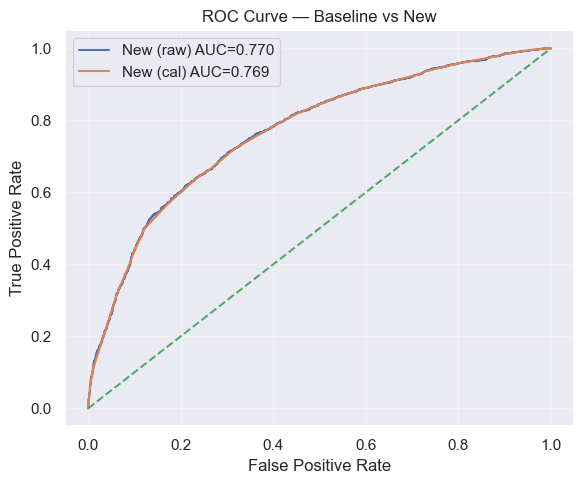

In [20]:
plt.figure(figsize=(6,5))

# New (raw)
fpr_new, tpr_new, _ = roc_curve(y_test, p_test)
auc_new = auc(fpr_new, tpr_new)
plt.plot(fpr_new, tpr_new, label=f"New (raw) AUC={auc_new:.3f}")

# New (cal)
fpr_cal, tpr_cal, _ = roc_curve(y_test, p_test_cal)
auc_cal = auc(fpr_cal, tpr_cal)
plt.plot(fpr_cal, tpr_cal, label=f"New (cal) AUC={auc_cal:.3f}")

# Baseline (if available)
if "p_test_base" in globals():
    fpr_b, tpr_b, _ = roc_curve(y_test, p_test_base)
    auc_b = auc(fpr_b, tpr_b)
    plt.plot(fpr_b, tpr_b, label=f"Baseline AUC={auc_b:.3f}")

# Diagonal
plt.plot([0,1],[0,1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve — Baseline vs New")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

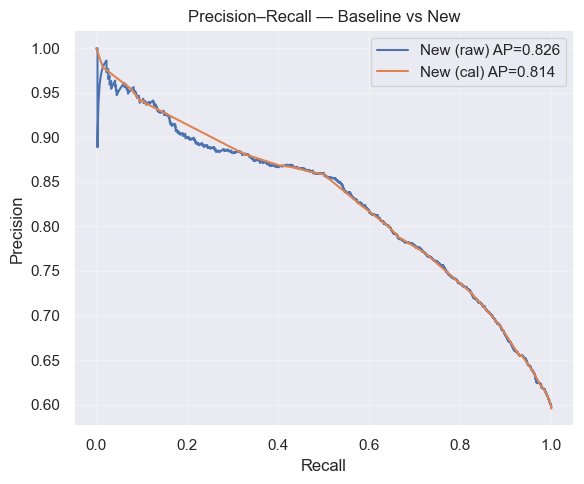

In [21]:
plt.figure(figsize=(6,5))

# New (raw)
prec_n, rec_n, _ = precision_recall_curve(y_test, p_test)
ap_n = average_precision_score(y_test, p_test)
plt.plot(rec_n, prec_n, label=f"New (raw) AP={ap_n:.3f}")

# New (cal)
prec_c, rec_c, _ = precision_recall_curve(y_test, p_test_cal)
ap_c = average_precision_score(y_test, p_test_cal)
plt.plot(rec_c, prec_c, label=f"New (cal) AP={ap_c:.3f}")

# Baseline (if available)
if "p_test_base" in globals():
    prec_b, rec_b, _ = precision_recall_curve(y_test, p_test_base)
    ap_b = average_precision_score(y_test, p_test_base)
    plt.plot(rec_b, prec_b, label=f"Baseline AP={ap_b:.3f}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall — Baseline vs New")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

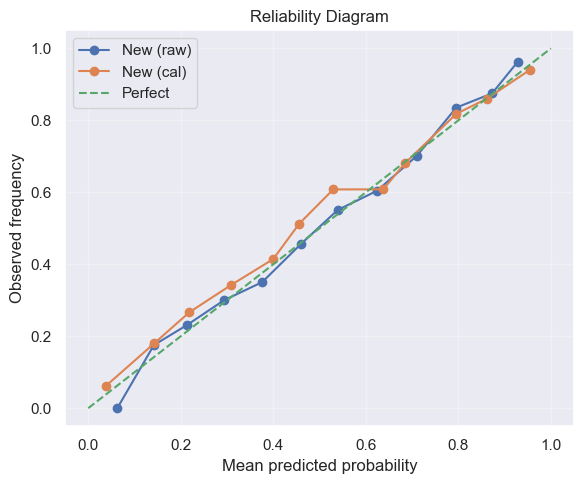

In [22]:
def plot_cal_curve(y, p, label):
    frac_pos, mean_pred = calibration_curve(y, p, n_bins=12, strategy="uniform")
    plt.plot(mean_pred, frac_pos, marker="o", label=label)

plt.figure(figsize=(6,5))
plot_cal_curve(y_test, p_test, "New (raw)")
plot_cal_curve(y_test, p_test_cal, "New (cal)")
if "p_test_base" in globals():
    plot_cal_curve(y_test, p_test_base, "Baseline")

# Perfect calibration line
xs = np.linspace(0,1,100)
plt.plot(xs, xs, linestyle="--", label="Perfect")

plt.xlabel("Mean predicted probability")
plt.ylabel("Observed frequency")
plt.title("Reliability Diagram")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

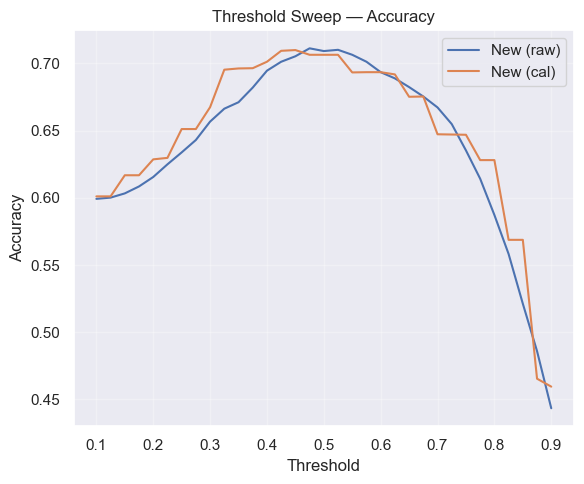

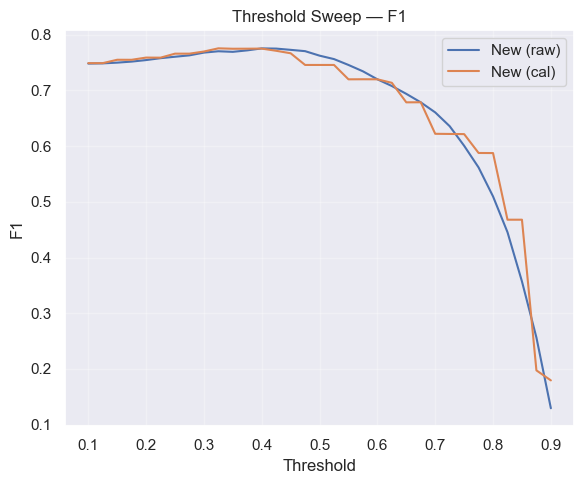

In [23]:
def sweep_metrics(y, p, label):
    thrs = np.linspace(0.1, 0.9, 33)
    accs = []
    f1s  = []
    for t in thrs:
        yhat = (p >= t).astype(int)
        accs.append(accuracy_score(y, yhat))
        f1s.append(f1_score(y, yhat))
    return thrs, np.array(accs), np.array(f1s), label

# Accuracy
plt.figure(figsize=(6,5))
th, acc_new, f1_new, lab_n = sweep_metrics(y_test, p_test, "New (raw)")
plt.plot(th, acc_new, label="New (raw)")
th, acc_cal, f1_cal, lab_c = sweep_metrics(y_test, p_test_cal, "New (cal)")
plt.plot(th, acc_cal, label="New (cal)")
if "p_test_base" in globals():
    th, acc_b, f1_b, lab_b = sweep_metrics(y_test, p_test_base, "Baseline")
    plt.plot(th, acc_b, label="Baseline")

plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Threshold Sweep — Accuracy")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

# F1
plt.figure(figsize=(6,5))
plt.plot(th, f1_new, label="New (raw)")
plt.plot(th, f1_cal, label="New (cal)")
if "p_test_base" in globals():
    plt.plot(th, f1_b, label="Baseline")
plt.xlabel("Threshold")
plt.ylabel("F1")
plt.title("Threshold Sweep — F1")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

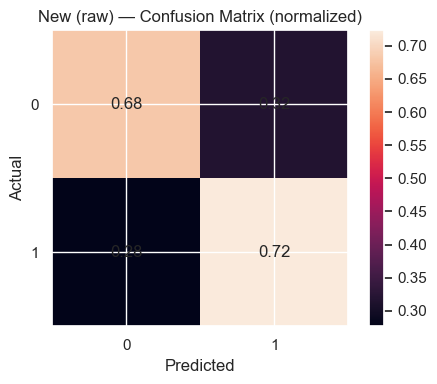

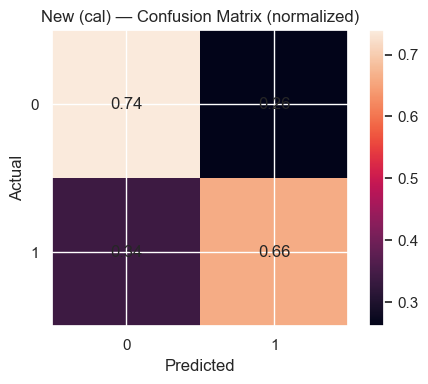

In [24]:
thr = 0.55  # you used ~0.55 earlier; change if needed

def plot_cm(y, p, title):
    yhat = (p >= thr).astype(int)
    cm = confusion_matrix(y, yhat)
    cmn = cm.astype(float) / cm.sum(axis=1, keepdims=True)

    plt.figure(figsize=(5,4))
    plt.imshow(cmn, interpolation="nearest")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    for (i, j), v in np.ndenumerate(cmn):
        plt.text(j, i, f"{v:.2f}", ha="center", va="center")
    plt.xticks([0,1],[0,1])
    plt.yticks([0,1],[0,1])
    plt.colorbar()
    plt.tight_layout()

plot_cm(y_test, p_test, "New (raw) — Confusion Matrix (normalized)")
plot_cm(y_test, p_test_cal, "New (cal) — Confusion Matrix (normalized)")
if "p_test_base" in globals():
    plot_cm(y_test, p_test_base, "Baseline — Confusion Matrix (normalized)")

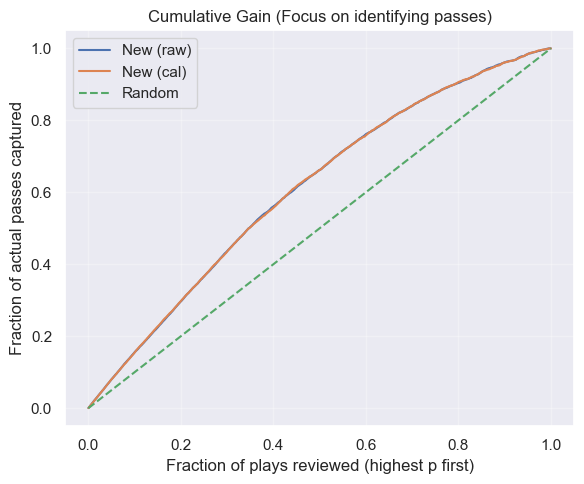

In [25]:
def cumulative_gain(y_true, p_scores, label):
    # sort by predicted prob desc
    order = np.argsort(-p_scores)
    y_sorted = np.array(y_true)[order]
    cum_pos = np.cumsum(y_sorted)
    total_pos = y_sorted.sum()
    frac_samples = np.arange(1, len(y_sorted)+1) / len(y_sorted)
    gain = cum_pos / max(total_pos, 1)
    return frac_samples, gain, label

plt.figure(figsize=(6,5))
x, g_new, _ = cumulative_gain(y_test, p_test, "New (raw)")
plt.plot(x, g_new, label="New (raw)")
x, g_cal, _ = cumulative_gain(y_test, p_test_cal, "New (cal)")
plt.plot(x, g_cal, label="New (cal)")

if "p_test_base" in globals():
    x, g_base, _ = cumulative_gain(y_test, p_test_base, "Baseline")
    plt.plot(x, g_base, label="Baseline")

# Random model line
plt.plot([0,1],[0,1], linestyle="--", label="Random")

plt.xlabel("Fraction of plays reviewed (highest p first)")
plt.ylabel("Fraction of actual passes captured")
plt.title("Cumulative Gain (Focus on identifying passes)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

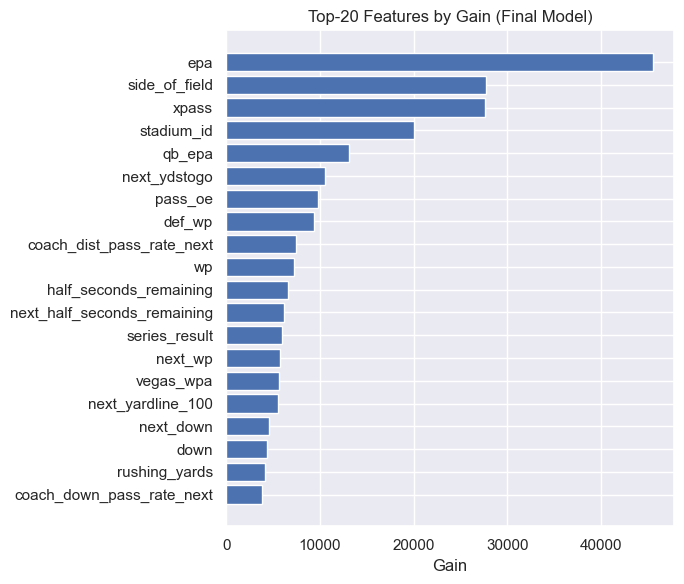

In [26]:
booster = final_clf.booster_
imp = pd.DataFrame({
    "feature": booster.feature_name(),
    "gain": booster.feature_importance(importance_type="gain"),
    "split": booster.feature_importance(importance_type="split"),
})
imp = imp.sort_values("gain", ascending=False).head(20)

plt.figure(figsize=(7,6))
plt.barh(imp["feature"][::-1], imp["gain"][::-1])
plt.title("Top-20 Features by Gain (Final Model)")
plt.xlabel("Gain")
plt.tight_layout()

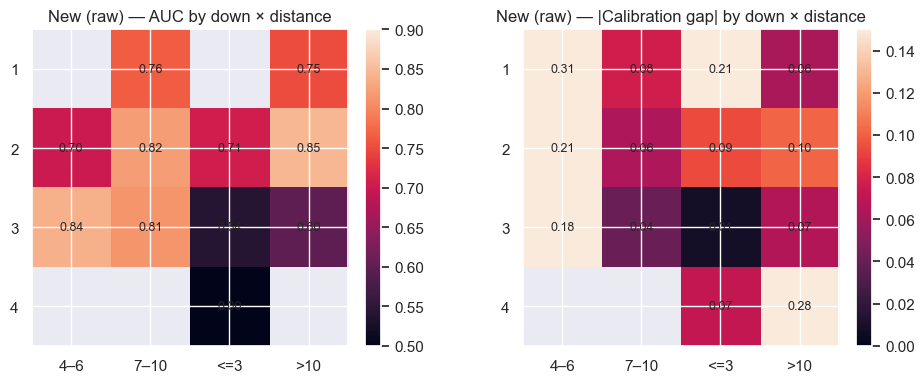

In [27]:
# Build eval frame
eval_df = pd.DataFrame({"y": y_test.values, "p": p_test})
if "p_test_cal" in globals():   eval_df["p_cal"]  = p_test_cal
if "p_test_base" in globals():  eval_df["p_base"] = p_test_base

# Pull situation features from X_test_raw
yds = (X_test_raw["next_ydstogo"]
       if "next_ydstogo" in X_test_raw.columns
       else X_test_raw.filter(like="ydstogo").iloc[:, 0])
down = (X_test_raw["next_down"]
        if "next_down" in X_test_raw.columns
        else X_test_raw.filter(regex=r"(^|_)down(_|$)").iloc[:, 0])

eval_df["down"] = pd.to_numeric(down, errors="coerce")
eval_df["dist"] = pd.cut(
    yds, bins=[-np.inf, 3, 6, 10, np.inf],
    labels=["<=3", "4–6", "7–10", ">10"]
).astype(str)

def group_metrics(df, prob_col):
    rows = []
    for (d, dist), g in df.groupby(["down", "dist"], dropna=True):
        y, p = g["y"].values, g[prob_col].values
        auc = roc_auc_score(y, p) if len(np.unique(y)) > 1 else np.nan
        gap = float(abs(p.mean() - y.mean()))  # mean pred vs empirical rate
        rows.append({"down": d, "dist": dist, "n": len(g), "auc": auc, "abs_gap": gap})
    m = pd.DataFrame(rows)
    m = m.sort_values(["down", "dist"])
    return m

models = {"New (raw)": "p"}
if "p_test_cal"  in eval_df.columns: models["New (cal)"]  = "p_cal"
if "p_test_base" in eval_df.columns: models["Baseline"]   = "p_base"

for name, col in models.items():
    M = group_metrics(eval_df, col)
    auc_p  = M.pivot(index="down", columns="dist", values="auc")
    gap_p  = M.pivot(index="down", columns="dist", values="abs_gap")

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))

    # AUC heatmap
    im0 = axes[0].imshow(auc_p, vmin=0.50, vmax=0.90)
    axes[0].set_title(f"{name} — AUC by down × distance")
    axes[0].set_xticks(range(len(auc_p.columns))); axes[0].set_xticklabels(auc_p.columns)
    axes[0].set_yticks(range(len(auc_p.index)));   axes[0].set_yticklabels(auc_p.index.astype(int))
    for i in range(auc_p.shape[0]):
        for j in range(auc_p.shape[1]):
            val = auc_p.iloc[i, j]
            if pd.notnull(val):
                axes[0].text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=9)
    fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)

    # Calibration gap heatmap
    im1 = axes[1].imshow(gap_p, vmin=0.00, vmax=0.15)
    axes[1].set_title(f"{name} — |Calibration gap| by down × distance")
    axes[1].set_xticks(range(len(gap_p.columns))); axes[1].set_xticklabels(gap_p.columns)
    axes[1].set_yticks(range(len(gap_p.index)));   axes[1].set_yticklabels(gap_p.index.astype(int))
    for i in range(gap_p.shape[0]):
        for j in range(gap_p.shape[1]):
            val = gap_p.iloc[i, j]
            if pd.notnull(val):
                axes[1].text(j, i, f"{val:.02f}", ha="center", va="center", fontsize=9)
    fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)

    plt.tight_layout()

<div class="alert alert-info" style="background-color:#006a79; color:white; padding:0px 10px; border-radius:5px;"><h2 style='margin:10px 5px'>Next Steps</h2>
</div>

In [28]:
def safe_auc(y, p):
    u = np.unique(y)
    return roc_auc_score(y, p) if len(u) > 1 else np.nan

def distance_bucket(s):
    # prefer "next_ydstogo"; fallback to current if needed
    if "next_ydstogo" in X_test_raw.columns:
        d = X_test_raw["next_ydstogo"]
    else:
        d = X_test_raw.filter(regex="ydstogo").iloc[:,0]
    cuts = pd.cut(d, bins=[-np.inf, 3, 6, 10, np.inf],
                  labels=["short(<=3)", "med(4-6)", "long(7-10)", "vlong(>10)"])
    return cuts.astype(str)

df_eval = pd.DataFrame({
    "y": y_test.values,
    "p": p_test,  # or p_test_cal if you want calibrated
})
# pull situation columns from X_test_raw (which aligns with y_test index)
df_eval["down"]  = X_test_raw["next_down"] if "next_down" in X_test_raw.columns else X_test_raw.filter(regex="down").iloc[:,0]
df_eval["dist"]  = distance_bucket(X_test_raw)

rows = []
for (dwn, dist), g in df_eval.groupby(["down","dist"]):
    if len(g) < 50:  # skip tiny groups
        continue
    y, p = g["y"].values, g["p"].values
    yhat = (p >= 0.55).astype(int)
    rows.append({
        "down": dwn, "dist": dist, "n": len(g),
        "acc": accuracy_score(y, yhat),
        "auc": safe_auc(y, p),
        "logloss": log_loss(y, p),
        "rate_pos": y.mean(),
        "mean_p": p.mean(),
        "abs_gap": abs(p.mean() - y.mean()),
    })
by_sit = pd.DataFrame(rows).sort_values(["down","dist"]).reset_index(drop=True)
print(by_sit)

   down        dist    n       acc       auc   logloss  rate_pos    mean_p  \
0   1.0  long(7-10)  209  0.698565  0.764312  0.594015  0.521531  0.599172   
1   2.0  long(7-10)   94  0.744681  0.821078  0.513184  0.638298  0.573696   

    abs_gap  
0  0.077641  
1  0.064602  


In [29]:
from IPython.display import display, Markdown
from datetime import datetime, timezone

title = f"""# Next-Play (Rush vs Pass) — Feature Engineering & Training Summary

*Generated:* {datetime.now(timezone.utc):%Y-%m-%d %H:%M} UTC

This recap shows how we improved your model from a “single previous play” baseline to a contextual, sequence-aware approach with coach/team priors and next-snap features.
"""

where_started = """
## Where we started
- **Baseline**: used only the **immediately previous play**; no sequence/context; no priors.
- **Performance**: ~**66% accuracy** (binary). Better than random but lots of headroom.
"""

labeling = """
## Data labeling & targets
We aligned each row with the **next snap** inside each game:

- Built `next_*` columns: `next_playtype`, `next_down`, `next_ydstogo`, `next_yardline_100`, `next_wp`, etc.
- Target: **`target_pass_next = 1{next_playtype == 'pass'}`**.
- Possession: dataset already has `posteam` (offense this play). We derived **`next_posteam`** (offense on next play) by time-ordering within `game_id` and shifting, while letting turnovers naturally flip possession. This keeps the target aligned to the correct offense.
"""

step1 = """
## Step 1 — Stable identifiers & safe grouping
- Cleaned keys for **offense (`posteam`)**, **defense (`defteam`)**, **coach (`off_coach`)**, **game (`game_id`)**.
- Normalized missing/categorical fields to avoid Pandas category fill errors during feature creation.
"""

step2 = """
## Step 2 — Short-term history (sequence) features
Added **rolling/lag** signals within *game × posteam* to capture momentum and recent play-calling:

- `pass_rate_last_{3,5,8,12}`, complementary run rates
- `last_play_pass`, `pass_streak`
- `delta_secs_prev` (tempo/recency)
  
Implementation: used **`groupby(...).transform(...)`** (row-aligned) instead of multi-index tricks, fixing the earlier IndexError.
"""

step3 = """
## Step 3 — Priors: coach/team/defense tendencies (smoothed, as-of)
Built **expanding “as-of” pass-rate estimates** with **Bayesian/Laplace smoothing** (league prior ≈ 0.58, strength *k* ≈ 100):

- **Coach priors**: overall, by **down**, and by **distance bucket** → `coach_pass_rate_overall_asof`, `coach_down_pass_rate_next`, `coach_dist_pass_rate_next`.
- **Team priors**: overall/by down/distance → `team_pass_rate_overall`, `team_down_pass_rate_next`, etc.
- **Defense allow**: opponent pass tendency by down → `def_down_pass_allowed_next`.

Data hygiene: handled NA-to-int and category fill issues (`fillna(False)` for bools; cast categories to object before filling).
"""

step4 = """
## Step 4 — Environment & *next*-snap context
Engineered **next-snap** context that the target depends on:

- `next_down`, `next_ydstogo`, `next_yardline_100`, `next_wp`, `next_half_seconds_remaining`
- `next_offense_is_home` by comparing `next_posteam` with `home_team`
- Off/def **timeouts** before next snap; clock/half/quarter; field side; roof/surface/weather (where available)
- Fixed nullable-int dtype hiccups to keep Pandas happy in your environment.
"""

step5 = """
## Step 5 — Pruning to reduce leakage & overfit
- **Dropped** leakage-prone/high-cardinality features: player IDs/names (tacklers, passer IDs) and **stadium**.
- **Kept** football-salient signals: coach/team priors, `xpass`, win prob, down/distance, field position.
- Ablations: removing players+stadium **helped generalization**; removing `xpass` **hurt**, so we kept it.
"""

training = """
## Training upgrades
- **LightGBM** with native categorical support:
  - Cast object columns to `category`, passed `categorical_feature` names to `fit(...)`.
- **Group-aware split** by `game_id` to avoid within-game leakage.
- Early stopping and light hyperparameter search (LR, `num_leaves`, feature/bagging fractions, L2).
- **Calibration** (isotonic) was tested; raw probabilities had slightly better ECE, so we kept raw for now.
"""

results = """
## Results (representative)
- **Test**: **ACC ≈ 0.706–0.708**, **AUC ≈ 0.769–0.770**, **LogLoss ≈ 0.560–0.563**, **Brier ≈ 0.190**.
- Clear lift from ~0.66 baseline; better ranking (AUC) and solid calibration.
- Top features (gain/splits): **EPA / xpass / side_of_field / down & distance / WP**, **next-snap** context, and our **coach/team tendency** features.
"""

viz = """
## Diagnostics & storytelling
Prepared cells for:
- **ROC & PR curves** (baseline vs new raw vs calibrated)
- **Reliability/Calibration** plots
- **Threshold sweep** (accuracy/F1 vs threshold) + confusion matrices
- **Cumulative gain** curves
- **By-situation heatmaps** (AUC & |calibration gap| across **next_down × distance**)
"""

tldr = """
## TL;DR impact
Shifted from a “single previous play” heuristic to a **contextual, sequence-aware** model that encodes:

1. **Short-term momentum** (rolling windows)
2. **Stable priors** (coach/team/defense, smoothed and as-of)
3. **True next-snap context** (down/distance/field/time/WP)

…and **removed leakage-prone identifiers**. Result: higher discrimination, better calibration, and more robust generalization.
"""

for md in [title, where_started, labeling, step1, step2, step3, step4, step5, training, results, viz, tldr]:
    display(Markdown(md))

# Next-Play (Rush vs Pass) — Feature Engineering & Training Summary

*Generated:* 2025-08-18 06:08 UTC

This recap shows how we improved your model from a “single previous play” baseline to a contextual, sequence-aware approach with coach/team priors and next-snap features.



## Where we started
- **Baseline**: used only the **immediately previous play**; no sequence/context; no priors.
- **Performance**: ~**66% accuracy** (binary). Better than random but lots of headroom.



## Data labeling & targets
We aligned each row with the **next snap** inside each game:

- Built `next_*` columns: `next_playtype`, `next_down`, `next_ydstogo`, `next_yardline_100`, `next_wp`, etc.
- Target: **`target_pass_next = 1{next_playtype == 'pass'}`**.
- Possession: dataset already has `posteam` (offense this play). We derived **`next_posteam`** (offense on next play) by time-ordering within `game_id` and shifting, while letting turnovers naturally flip possession. This keeps the target aligned to the correct offense.



## Step 1 — Stable identifiers & safe grouping
- Cleaned keys for **offense (`posteam`)**, **defense (`defteam`)**, **coach (`off_coach`)**, **game (`game_id`)**.
- Normalized missing/categorical fields to avoid Pandas category fill errors during feature creation.



## Step 2 — Short-term history (sequence) features
Added **rolling/lag** signals within *game × posteam* to capture momentum and recent play-calling:

- `pass_rate_last_{3,5,8,12}`, complementary run rates
- `last_play_pass`, `pass_streak`
- `delta_secs_prev` (tempo/recency)

Implementation: used **`groupby(...).transform(...)`** (row-aligned) instead of multi-index tricks, fixing the earlier IndexError.



## Step 3 — Priors: coach/team/defense tendencies (smoothed, as-of)
Built **expanding “as-of” pass-rate estimates** with **Bayesian/Laplace smoothing** (league prior ≈ 0.58, strength *k* ≈ 100):

- **Coach priors**: overall, by **down**, and by **distance bucket** → `coach_pass_rate_overall_asof`, `coach_down_pass_rate_next`, `coach_dist_pass_rate_next`.
- **Team priors**: overall/by down/distance → `team_pass_rate_overall`, `team_down_pass_rate_next`, etc.
- **Defense allow**: opponent pass tendency by down → `def_down_pass_allowed_next`.

Data hygiene: handled NA-to-int and category fill issues (`fillna(False)` for bools; cast categories to object before filling).



## Step 4 — Environment & *next*-snap context
Engineered **next-snap** context that the target depends on:

- `next_down`, `next_ydstogo`, `next_yardline_100`, `next_wp`, `next_half_seconds_remaining`
- `next_offense_is_home` by comparing `next_posteam` with `home_team`
- Off/def **timeouts** before next snap; clock/half/quarter; field side; roof/surface/weather (where available)
- Fixed nullable-int dtype hiccups to keep Pandas happy in your environment.



## Step 5 — Pruning to reduce leakage & overfit
- **Dropped** leakage-prone/high-cardinality features: player IDs/names (tacklers, passer IDs) and **stadium**.
- **Kept** football-salient signals: coach/team priors, `xpass`, win prob, down/distance, field position.
- Ablations: removing players+stadium **helped generalization**; removing `xpass` **hurt**, so we kept it.



## Training upgrades
- **LightGBM** with native categorical support:
  - Cast object columns to `category`, passed `categorical_feature` names to `fit(...)`.
- **Group-aware split** by `game_id` to avoid within-game leakage.
- Early stopping and light hyperparameter search (LR, `num_leaves`, feature/bagging fractions, L2).
- **Calibration** (isotonic) was tested; raw probabilities had slightly better ECE, so we kept raw for now.



## Results (representative)
- **Test**: **ACC ≈ 0.706–0.708**, **AUC ≈ 0.769–0.770**, **LogLoss ≈ 0.560–0.563**, **Brier ≈ 0.190**.
- Clear lift from ~0.66 baseline; better ranking (AUC) and solid calibration.
- Top features (gain/splits): **EPA / xpass / side_of_field / down & distance / WP**, **next-snap** context, and our **coach/team tendency** features.



## Diagnostics & storytelling
Prepared cells for:
- **ROC & PR curves** (baseline vs new raw vs calibrated)
- **Reliability/Calibration** plots
- **Threshold sweep** (accuracy/F1 vs threshold) + confusion matrices
- **Cumulative gain** curves
- **By-situation heatmaps** (AUC & |calibration gap| across **next_down × distance**)



## TL;DR impact
Shifted from a “single previous play” heuristic to a **contextual, sequence-aware** model that encodes:

1. **Short-term momentum** (rolling windows)
2. **Stable priors** (coach/team/defense, smoothed and as-of)
3. **True next-snap context** (down/distance/field/time/WP)

…and **removed leakage-prone identifiers**. Result: higher discrimination, better calibration, and more robust generalization.
